<a href="https://colab.research.google.com/github/saadam1n/CS4803-EML/blob/main/lab0/lab0_task3_Saad_Amin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pleas read:

before your start running this jupyter notebook, please click Edit > Notebook Settings and choose any of the available GPUs.

## 0. Import Python Packages

Install thop if not install already:

In [ ]:
%pip install thop

Import all packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: you may import more packages below:
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import tqdm

import matplotlib.pyplot as plt

from torch.profiler import profile, ProfilerActivity, record_function
import torch.cuda.profiler as profiler

from thop import profile

## 1. Define your first network

In [2]:
# ResNet Block
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.silu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x)
        out = F.silu(out)
        return out

# MobileNetV2 block
class MobileNetV2Block(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(MobileNetV2Block, self).__init__()

        expansion_ratio = 4
        mid_planes = planes * expansion_ratio

        self.net = nn.Sequential(
            nn.Conv2d(in_planes, mid_planes, kernel_size=1, bias=False),
            nn.GELU(),
            nn.Conv2d(mid_planes, mid_planes, groups=mid_planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.GELU(),
            nn.Conv2d(mid_planes, planes, kernel_size=1, bias=False),
            nn.BatchNorm2d(planes)
        )


        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.net(x) + self.shortcut(x)
        return out

# https://arxiv.org/abs/2111.11418
class PoolFormerBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(PoolFormerBlock, self).__init__()

        self.pooler = nn.Sequential(
            nn.BatchNorm2d(in_planes),
            nn.MaxPool2d(kernel_size=3, stride=stride, padding=1)
        )

        self.ffn = nn.Sequential(
            nn.BatchNorm2d(in_planes),
            nn.Conv2d(in_planes, planes * 2, kernel_size=1, stride=1, bias=False),
            nn.SiLU(),
            nn.Conv2d(planes * 2, planes, kernel_size=1, stride=1, bias=False)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.BatchNorm2d(in_planes),
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, bias=False),
            )

    def forward(self, x):
        out = self.pooler(x) + x
        out = self.ffn(out) + self.shortcut(out)

        return out


# ResNet Model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # we utilize lazy in places to make it compatible with both CIFAR and MNIST

        self.conv1 = nn.LazyConv2d(64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.LazyLinear(num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(MobileNetV2Block, [2, 2, 2, 2])

## 2. Implement training loop and test function

In [3]:
# I put in quite a bit of extra stuff to profile/optimizing training
# since I have an interview coming where I need to do that

def train(model, device, train_loader, optimizer, scheduler, epoch):
    model.train()


    running_loss = 0.0
    correct = 0
    total = 0
    loss_curve = []

    scaler = torch.amp.GradScaler("cuda")

    print_acc = False

    for epoch in tqdm.tqdm(range(epoch)):
      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)

          optimizer.zero_grad()

          with torch.autocast(device_type="cuda", dtype=torch.float16):
              output = model(data)
              loss = F.cross_entropy(output, target)

          scaler.scale(loss).backward()

          scaler.step(optimizer)
          scaler.update()

          running_loss += loss.item()

          if batch_idx % 100 == 0:
              loss_curve.append(loss.item())

              if print_acc:
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()

                print(f'Batch {batch_idx}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

      scheduler.step()



    return loss_curve

def test(model, device, test_loader):
    # TODO: finish this function, you are required to:
    # 1. print the loss and classification accuracy on the test set
    with torch.no_grad():
      model.eval()

      running_loss = 0.0

      correct = 0
      total = 0

      for batch_idx, (data, target) in test_loader:
          data, target = data.to(device), target.to(device)

          with torch.autocast(device_type="cuda", dtype=torch.float16):
            output = model(data)
            loss = F.cross_entropy(output, target)

          _, predicted = output.max(1)
          total += target.size(0)
          correct += predicted.eq(target).sum().item()

          running_loss += loss.item()

      print(f'Loss: {running_loss / len(test_loader):.4f}, Acc: {100.*correct/total:.2f}%')


## 3. Dataset loading


In [4]:
# TODO: finish the code here, you are required to:
# 1. load the training and testing split of the MNIST dataset

load_mnist = False

if load_mnist:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(
        root="./data",
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = datasets.MNIST(
        root="./data",
        train=False,
        download=True,
        transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
else:
    # Data transforms
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # Dataset and DataLoader
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                 download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                download=True, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=384, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, pin_memory=True)




100%|██████████| 170M/170M [00:09<00:00, 18.6MB/s]


## 4. Put Everything Together

Regular ResNet:

- MNIST: Loss: 0.0178, Acc: 99.54%

- CIFAR: Loss: 0.4036, Acc: 87.25%

MobileNetV2:

- CIFAR: Loss: 0.3543, Acc: 88.74%


100%|██████████| 16/16 [07:38<00:00, 28.67s/it]


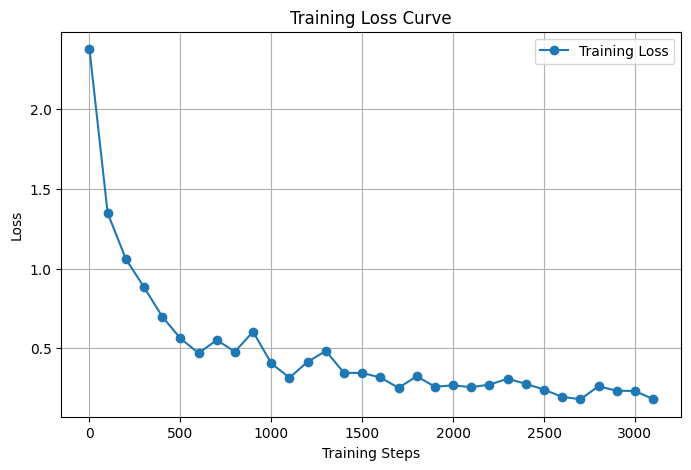

Loss: 0.3543, Acc: 88.74%


In [5]:
# TODO: finish the code here, you are required to:
# 1. launch model training: recommended hyperparameter: batch size = 64, learning rate = 1.0, adam optimizer
# 2. visualize the training loss curve using matplotlib or any other libraries

latency_test_only = True

device = torch.device("cuda")

model = ResNet18()
model.to(device)
model.compile()

if not latency_test_only:
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

    losses = train(model, device, train_loader, optimizer, scheduler, 16)

    steps = [i * 100 for i in range(len(losses))]

    plt.figure(figsize=(8, 5))
    plt.plot(steps, losses, marker='o', label="Training Loss")

    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# run test
test(model, device, test_loader)